# PULSEE $\frac{\pi}{2}$ - Pulse, a Simple Zeeman Interaction

#### Jiwoo Seo, Ilija N.

## Imports

In [1]:
import numpy as np 
import pandas as pd
from pulsee import simulation as sim, quantum_computing as qc, operators as op
import qutip as qt 
# import matplotlib.pylab as plt

## Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 5.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 2 \pi$ T:

In [2]:
QUANTUM_NUMBERS = [1/2] # spin 1/2
GAMMA_2PIS = [5 / (2 * np.pi)] # = gamma / 2pi
B0 = 2 * np.pi
W0 = -GAMMA_2PIS[0] * B0 * 2 * np.pi # Careful with the sign AND DON'T FORGET * 2PI (radial frequency)

zeem_par = {'field magnitude' : B0, 'theta_z' : 0, 'phi_z' : 0}

In [3]:
print('Larmor frequency:', W0/(2*np.pi), 'MHz')

Larmor frequency: -5.0 MHz


## Experiment Settings

In [37]:
ACQUISITION_TIME = 50 # in microseconds
T2 = 10

## Hamiltonians
Here we add the desired Hamiltonian interaction terms. Add these to the following dictionary `args` with key as it appears in `nuclear_system_setup` function. The value should be the parameters of the associated Hamiltonian as it appears in `nuclear_system_setup`.

In [5]:
h_dict = {
}

### Run `sim.nuclear_system_setup` after setting up the arguments

In [6]:
args = h_dict.copy()
spin_par = []
for qn, gam in zip(QUANTUM_NUMBERS, GAMMA_2PIS):
    spin_par.append({'quantum number': qn, 'gamma/2pi': gam})

args['spin_par'] = spin_par 
args['zeem_par'] = zeem_par
# Initial state is canocial
spin, h_unperturbed, rho_0 = sim.nuclear_system_setup(**args)

In [7]:
Iz = spin.I['z']
Ix = spin.I['x']
Iy = spin.I['y']

## Pulse
Set up single mode pulse of form 
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively.

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 10 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$ --> $I_x$ pulse.

In [8]:
B1 = B0 / 10
PHASE_B1 = 0
POLAR_B1 = np.pi / 2
AZIMUTHAL_B1 = 0
TIP_ANGLE = -np.pi / 2
PULSE_TIME = -TIP_ANGLE / (2 * np.pi* GAMMA_2PIS[0] * B1) # using gamma/2pi, NOT gamma!

# used in sim.evolve()
mode = pd.DataFrame([(W0, B1, PHASE_B1, POLAR_B1, AZIMUTHAL_B1)],
                    columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

In [9]:
PULSE_TIME

0.5

##  Simulation

In [10]:
# For the Magnus solver, defines the rotating reference frame
RRF_par = {'nu_RRF': W0/(2*np.pi), 'theta_RRF' : 0, 'phi_RRF' : 0}

In [11]:
#Evolve the intial state until a square pi/2 pulse is applied using the magnus solver in the interaction picture
evolved_dm = sim.evolve(spin, h_unperturbed, rho_0, solver='magnus', picture='IP',
						mode=mode, pulse_time=PULSE_TIME, n_points=30, order=1)
evolved_dm

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 624.95it/s]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j         0. +0.49999972j]
 [0. -0.49999972j 0.5+0.j        ]]

In [12]:
#Evolve the intial state until a square pi/2 pulse is applied using the magnus solver 
evolved_dm_magnus = sim.evolve(spin, h_unperturbed, rho_0, solver='magnus', picture='RRF', RRF_par=RRF_par,
						mode=mode, pulse_time=PULSE_TIME, n_points=30, order=1)
evolved_dm_magnus

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 600.02it/s]


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j         0. +0.49999972j]
 [0. -0.49999972j 0.5+0.j        ]]

In [13]:
evolved_dm_mesolve = sim.evolve(spin, h_unperturbed, rho_0, solver='mesolve',
						mode=mode, pulse_time=PULSE_TIME, n_points=10)
evolved_dm_mesolve

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.00s. Est. time left: 00:00:00:00
70.0%. Run time:   0.00s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 5.00000000e-01+0.j         -8.26606145e-13+0.49999972j]
 [-8.26606145e-13-0.49999972j  5.00000000e-01+0.j        ]]

## Compare initial and final density density matrix

In [23]:
sim.apply_rot_pulse(rho_0, np.pi/2, Ix)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j         0. +0.49999972j]
 [0. -0.49999972j 0.5+0.j        ]]

In [26]:
evolved_dm

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j         0. +0.49999972j]
 [0. -0.49999972j 0.5+0.j        ]]

Intial state


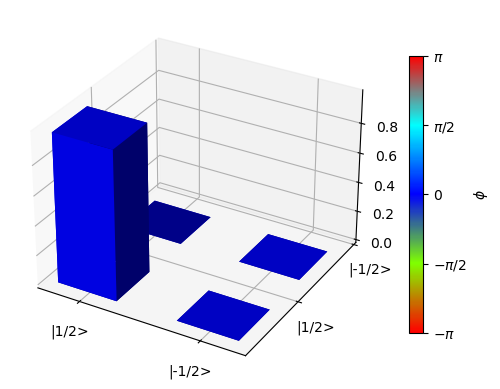

Evolved


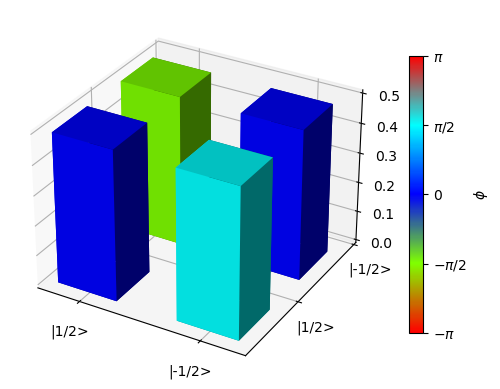

(<Figure size 640x480 with 2 Axes>, <Axes3DSubplot: >)

In [29]:
print('Intial state')
sim.plot_complex_density_matrix(rho_0)
print('Evolved')
sim.plot_complex_density_matrix(evolved_dm)

# Generate FID

In [50]:
t, fid = sim.FID_signal(spin, h_unperturbed, evolved_dm, 
						acquisition_time=ACQUISITION_TIME, T2=T2, n_points=20)
						

In [57]:
f, ft = sim.fourier_transform_signal(fid, t, padding=2)

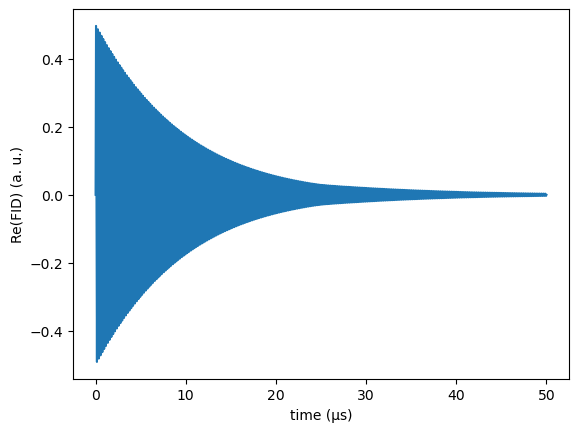

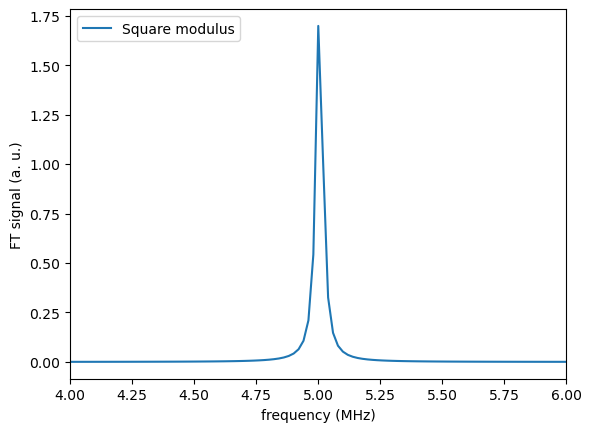

In [58]:
sim.plot_real_part_FID_signal(t, fid)
_ = sim.plot_fourier_transform(f, ft, square_modulus=True, save=False, xlim=(4, 6),)